# Dimensionality Reduction

Ideally, one would not need to extract or select feature in the input data. However, reducing the dimensionality as a separate pre-processing steps may be advantageous:

1. The complexity of the algorithm depends on the number of input dimensions and size of the data.
2. If some features are unecessary, not extracting them saves compute time
3. Simpler models are more robust on small datasets
4. Fewer features lead to a better understanding of the data.
5. Visualization is easier in fewer dimensions.


Feature *selection* finds the dimensions that explain the data without loss of information and ends with a smaller dimensionality of the input data. A *forward selection* approach starts with one variable that decreases the error the most and add one by one. A *backward selection* starts with all variables and removes them one by one.

Feature *extraction* finds a new set of dimension as a combination of the original dimensions. They can be supervised or unsupervised depending on the output information. Examples are **Principal Component Analysis**, **Independent Component Analysis** **Linear Discriminant Analysis**


## Principal Component Analysis

PCA is an unsupervised learning method that finds the mapping from the input to a lower dimemsional space with minimum loss of information. First, we will download again our GPS time series from Oregon.

In [1]:
# Import useful modules
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
%matplotlib inline
from sklearn.decomposition import PCA

In [2]:
# Download data and save into a pandas.
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)

Text(0.5, 0, 'Vertical motions (mm)')

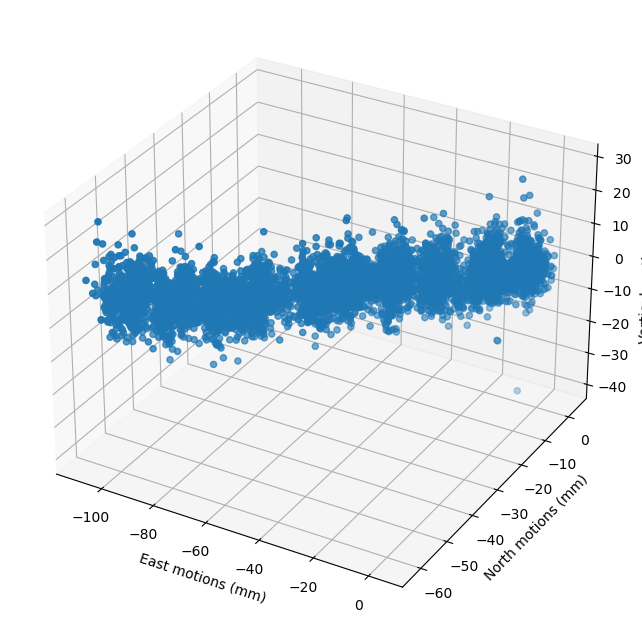

In [3]:
# Extract the three data dimensions
E = np.asarray(ue)# East component
N = np.asarray(un)# North component
U = np.asarray(uv)# Vertical component


fig=plt.figure(figsize=(11,8))
ax=fig.add_subplot(projection='3d')
# viridis = cm.get_cmap('viridis', len(E))
# print(viridis)
# ax.scatter(E,N,U,cmap=viridis,norm=True);ax.grid(True)
ax.scatter(E,N,U);ax.grid(True)
ax.set_xlabel('East motions (mm)')
ax.set_ylabel('North motions (mm)')
ax.set_zlabel('Vertical motions (mm)')


WORK IN PROGRESS


PCA idenditfies the axis that accounts for the largest amount of variance in the data. Let's  $\mathbf{Y} = \mathbf{y}_1,\cdots,\mathbf{y}_n $ be the data. Each row of $\mathbf{Y}$ is different measurements for single experiments (e.g., single time stamps). Each column of $ \mathbf{Y} $ is the same measurement repeated over several experiments (or time).  The steps to PCA are:
* center and standardize the data by substracting mean of each row of $\mathbf{Y} $  (all measurements at a single experiment or time stamp)
* Calculate the covariance matrix of the data
* Calculate the Singular Value Decomposition (SVD) of the data.



PCA uses the *(Singular Value Decomposition (SVD)* to decompose the data covariance matrix $\mathbf{C} $:

$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T ,$

where $\mathbf{V}^T$ contains the eigenvectors, or principal components. The *PCs* are normalized, centered around zero.

The *1st principal component* eigenvector that has the highest eigenvalue in the direction that has the highest variance.

In [4]:
# Organize your data in a matrix
X = np.vstack([E,N,U]).transpose()
print(U.shape)
print(X.shape)

(6086,)
(6086, 3)


In *PCA*, the input data is centered but not scaled for each feature before applying the SVD.



In [5]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3).fit(X)# retain all 3 components
print(pca)

PCA(n_components=3)


In [6]:
# The 3 PCs
print(pca.components_)

[[-0.88025917 -0.47388028  0.0241097 ]
 [-0.04281483  0.02872139 -0.9986701 ]
 [ 0.47255761 -0.88012076 -0.04557137]]


In [7]:
# The 3 PCs' explained variance
print(pca.explained_variance_)

[1248.23439358   29.50088343    3.22684049]


[-50.21607197 -28.86452235]
-3296.3092976281396


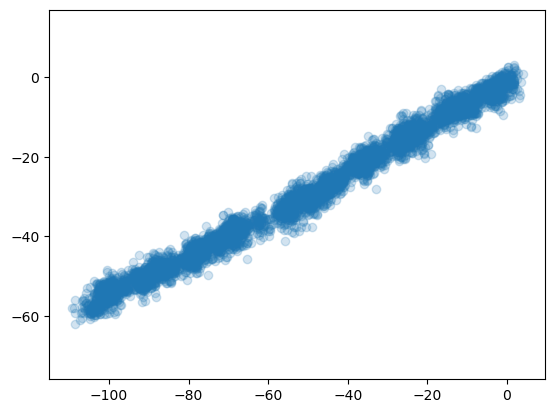

In [8]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
v= pca.components_[0,:] * 3 * pca.explained_variance_[0]
print(pca.mean_[:-1])
print(v[0])
draw_vector(pca.mean_[:-1], pca.mean_[:-1] + v[0])
plt.axis('equal');

[0.97445067 0.02303025 0.00251908]


Text(0.5, 1.0, 'Variance explained with cumulated PCs')

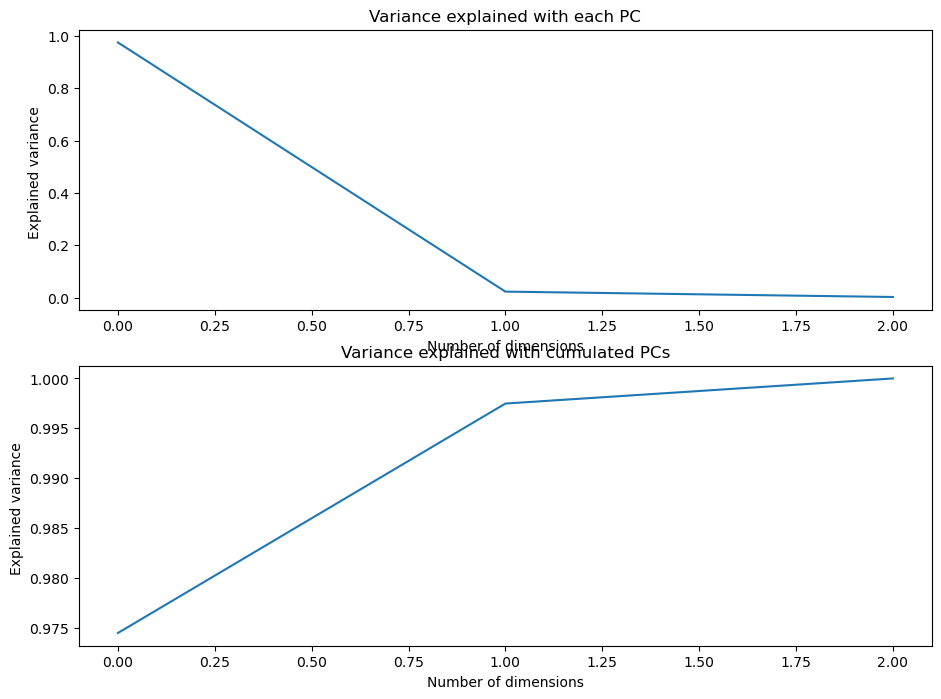

In [9]:
# The 3 PCs' explained variance ratio: how much of the variance is explained by each component
print(pca.explained_variance_ratio_)
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_xlabel('Number of dimensions')
ax[0].set_ylabel('Explained variance ')
ax[0].set_title('Variance explained with each PC')
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of dimensions')
ax[1].set_ylabel('Explained variance ')
ax[1].set_title('Variance explained with cumulated PCs')

Now we see that 97% of the variance is explained by the first PC. We can reduce the dimension of our system by only working with a single dimension. Another way to choose the number of dimensions is to select the minimum of PCs that would explain 95% of the variance.

In [10]:
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) +1
print("minimum dimension size to explain 95% of the variance ",d)

minimum dimension size to explain 95% of the variance  1


In [17]:
pca = PCA(n_components=d).fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
print(X[1:3,:])
print(X_pca[1:3,:])

original shape:    (2000, 3)
transformed shape: (2000, 1)
[[ 0.03932519  1.06492993 -1.58715033]
 [-0.40766041  0.39786915 -1.90998106]]
[[0.86272641]
 [1.6629138 ]]


direction of the plate  241.70456397212095  degrees from North


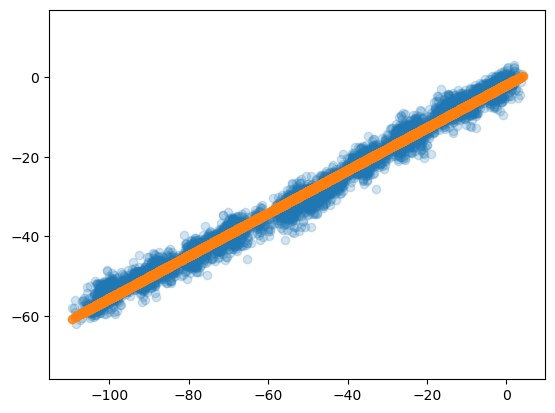

In [12]:
# Find the azimuth of the displacement vector
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

# Print out the azimuth and norm 
import math
azimuth=math.degrees(math.atan2(pca.components_[0][0],pca.components_[0][1]))
if azimuth <0:azimuth+=360
print("direction of the plate ",azimuth," degrees from North")

*SVD* can be computationally intensive for larger dimensions. It is recommended to use a **randomized PCA** to approximate the first principal components. Scikit-learn automatically switches to randomized PCA in either the following happens: data size > 500, number of vectors is > 500 and the number of PCs selected is less than 80% of either one.

## Independent Component Analysis

ICA is used to estimate sources given noisy measurements. It is frequently used in Geodesy to isolate contributions from earthquakes and hydrology. 

In [13]:
from scipy import signal
from sklearn.decomposition import FastICA

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# create 3 source signals
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal


S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

print(S)



[[ 0.495126    0.07841108 -1.31840023]
 [ 0.64019598  1.34570272 -1.94657351]
 [ 0.28913069  0.9500949  -1.646886  ]
 ...
 [-0.38561943 -0.71624672  1.34043406]
 [-0.50777458 -1.24052539  1.74176784]
 [-0.5550078  -0.90265774 -1.54534953]]


In [14]:
# Mix data
# create 3 signals at 3 receivers:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations


# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(A_,A)
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


[[-46.02147955  42.50809743  45.32804372]
 [-44.05919471  21.19031463  88.65606826]
 [-91.72748329  61.75542772  44.5776646 ]] [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


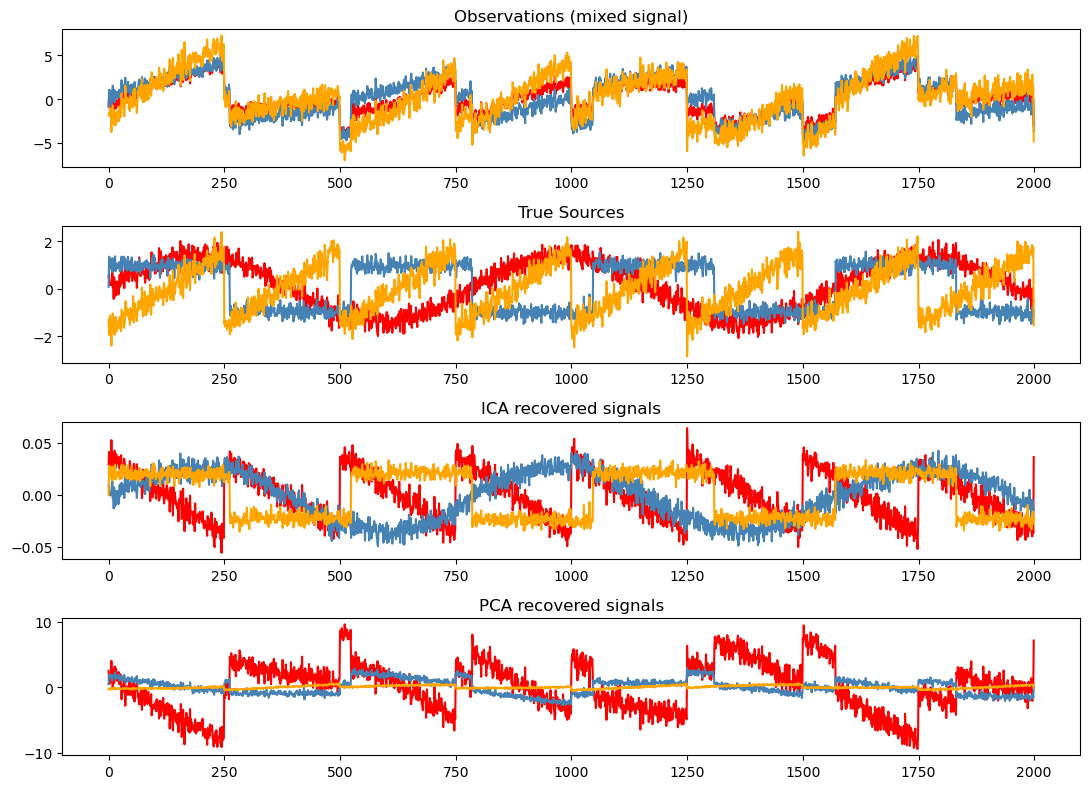

In [15]:
plt.figure(figsize=(11,8))
models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

## Other Techniques


1. Random Projections
https://scikit-learn.org/stable/modules/random_projection.html
2. Multidimensional Scaling
3. Isomap
4. t-Distributed stochastic neighbor embedding
5. Linear discriminant analysis